In [1]:
import numpy as np
from cellpose import utils
import numpy as np
import tifffile
from shapely.geometry import Polygon, box

In [2]:
fullres_chanel_0 = r"G:\Alexis_data\Project\SpatialOmics_cellpose\data\output-XETG00245__0034182__1835os__20240613__195055\morphology_focus\morphology_focus_0000.ome.tif"

def get_image_shape(file_path):
    with tifffile.TiffFile(file_path) as tif:
        image = tif.asarray()
        shape = image.shape
    return shape

# Usage
shape = get_image_shape(fullres_chanel_0)
print(f"Image shape: {shape}")

<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


Image shape: (4, 20532, 19968)


In [3]:
ROI_filepath = "G:/Alexis_data/Project/SpatialOmics_cellpose/data/output-XETG00245__0034182__1835os__20240613__195055/1835os_corneasection.csv"

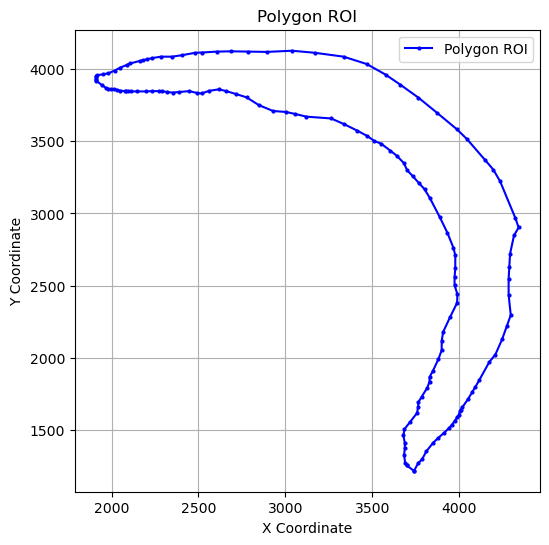

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the ROI coordinates from the CSV file
polygon_coords = pd.read_csv(ROI_filepath)

# Extract the X and Y coordinates
x_coords = polygon_coords['X']
y_coords = polygon_coords['Y']


# Create a plot
plt.figure(figsize=(6, 6))
plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b', label='Polygon ROI', markersize=2)

# Close the polygon by connecting the last point to the first
plt.plot([x_coords.iloc[0], x_coords.iloc[-1]], [y_coords.iloc[0], y_coords.iloc[-1]], 'b-')

# Adding labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title("Polygon ROI")
plt.legend()
plt.grid(True)

In [5]:
def crop_polygon_to_squares(polygon, square_size, overlap_size=40, with_overlap=True):
    """
    Crops a polygon into square regions of a given size, with or without overlap.

    Args:
        polygon (Polygon): The input polygon to crop.
        square_size (float): The base size of each square region (side length).
        overlap_size (float): The amount of overlap in um (default: 40).
        with_overlap (bool): Whether to include overlap between squares (default: True).

    Returns:
        List[Polygon]: List of square polygons that intersect with the input polygon.
    """
    # Get bounding box of the polygon
    minx, miny, maxx, maxy = polygon.bounds
    squares = []

    if with_overlap:
        # Generate grid of overlapping squares
        for x in range(int(minx), int(maxx), square_size):
            for y in range(int(miny), int(maxy), square_size):
                square = box(
                    x,                               # minx (unchanged)
                    y,                               # miny (unchanged)
                    x + square_size + overlap_size,  # maxx (expanded)
                    y + square_size + overlap_size   # maxy (expanded)
                )
                if polygon.intersects(square):
                    squares.append(square)
    else:
        # Generate grid of non-overlapping squares
        for x in range(int(minx), int(maxx), square_size):
            for y in range(int(miny), int(maxy), square_size):
                square = box(
                    x,                    # minx
                    y,                    # miny
                    x + square_size,      # maxx (no overlap)
                    y + square_size       # maxy (no overlap)
                )
                if polygon.intersects(square):
                    squares.append(square)

    return squares



In [6]:
# 1. Rescale the coordinates
# Levels: pixelsize in µm https://kb.10xgenomics.com/hc/en-us/articles/11636252598925
scalefactors = {
    0: 0.2125,
    1: 0.4250,
    2: 0.85,
    3: 1.7,
    4: 3.4,
    5: 6.8,
    6: 13.6,
    7: 27.2,
}

level = 0
pixelsize = scalefactors[level]

# Rescale the coordinates

scaling_factor = pixelsize
x_coords_rescaled = x_coords / scaling_factor
y_coords_rescaled = y_coords / scaling_factor

# Combine X and Y into coordinate pairs
rescaled_polygon_roi = list(zip(x_coords_rescaled, y_coords_rescaled))

# Create a Polygon object
rescaled_polygon_roi = Polygon(rescaled_polygon_roi)

square: POLYGON ((10869 17016, 10869 18898, 8987 18898, 8987 17016, 10869 17016))
 x: array('d', [10869.0, 10869.0, 8987.0, 8987.0, 10869.0]) 
 y: array('d', [17016.0, 18898.0, 18898.0, 17016.0, 17016.0])
square: POLYGON ((10869 18898, 10869 20780, 8987 20780, 8987 18898, 10869 18898))
 x: array('d', [10869.0, 10869.0, 8987.0, 8987.0, 10869.0]) 
 y: array('d', [18898.0, 20780.0, 20780.0, 18898.0, 18898.0])
square: POLYGON ((12751 17016, 12751 18898, 10869 18898, 10869 17016, 12751 17016))
 x: array('d', [12751.0, 12751.0, 10869.0, 10869.0, 12751.0]) 
 y: array('d', [17016.0, 18898.0, 18898.0, 17016.0, 17016.0])
square: POLYGON ((12751 18898, 12751 20780, 10869 20780, 10869 18898, 12751 18898))
 x: array('d', [12751.0, 12751.0, 10869.0, 10869.0, 12751.0]) 
 y: array('d', [18898.0, 20780.0, 20780.0, 18898.0, 18898.0])
square: POLYGON ((14633 17016, 14633 18898, 12751 18898, 12751 17016, 14633 17016))
 x: array('d', [14633.0, 14633.0, 12751.0, 12751.0, 14633.0]) 
 y: array('d', [17016.0, 

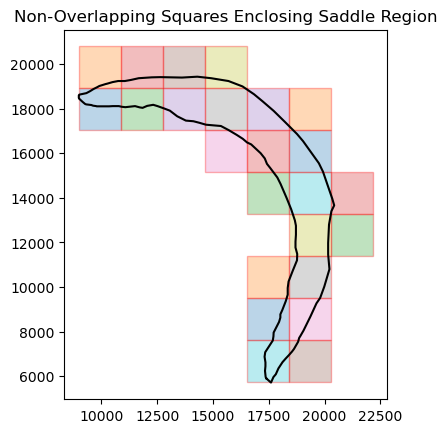

In [7]:


# Define square size
square_size = int(400/0.2125) # Adjust as necessary 


# For overlapping squares
# TODO: overlap_size/0.2125
overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, overlap_size=40/0.2125, with_overlap=True)

# For non-overlapping squares
non_overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, with_overlap=False)

# Visualization
fig, ax = plt.subplots()
# Plot the original polygon
x, y = rescaled_polygon_roi.exterior.xy
ax.plot(x, y, 'k-', label="Saddle-shaped Polygon")  # Black for polygon

# Plot the square regions
for square in non_overlapping_squares:
    print("square:", square)
    x, y = square.exterior.xy
    print(" x:", x,"\n", "y:", y)
    ax.fill(x, y, edgecolor='red', alpha=0.3, label="Red Square")

# Add labels and legend
ax.set_title(f"Non-Overlapping Squares Enclosing Saddle Region")
ax.set_aspect('equal', 'box')
# ax.legend(loc="upper left")
plt.show()

In [12]:


# Original image size
original_image_shape = (20532, 19968)  # Replace with the shape of your original image (H, W)

# Initialize a blank canvas for the combined masks
combined_mask = np.zeros(original_image_shape, dtype=np.uint16)

# Function to map segmentation outlines back to original coordinates
def map_to_original_coordinates(outlines, offset):

    min_x, min_y = offset
    
    return [outline + np.array([min_x, min_y]) for outline in outlines]

outlines_list = []

# Example processing loop for 3 cropped regions
for i, square in enumerate(overlapping_squares):
    
    # Stop the loop when i = 30 if 6 picture, set i + 1 = 5
    if i + 1 == 24:
        i1 = i + 1
        print("Reached the stopping condition: number = {i1}. Exiting the loop.")
        break

    print(f"Processing square {i + 1}: {square}")
    
    # Get bounding box of the current polygon (cropped region)
    min_x, min_y, max_x, max_y = map(int, square.bounds)

    # Load the segmentation result for the cropped region
    segmentation_file = f"G:/Alexis_data/Project/SpatialOmics_cellpose/results/segmenatation/1835os/cp_masks_cropped_square_com_{i + 1}_seg.npy"
    segmentation_data = np.load(segmentation_file, allow_pickle=True).item()
    
    # Extract outlines from    the segmentation
    outlines = utils.outlines_list(segmentation_data['masks'])

    # Map outlines back to original coordinates
    mapped_outlines = map_to_original_coordinates(outlines, (min_x, min_y))
    outlines_list.extend(mapped_outlines)

Processing square 1: POLYGON ((11057.235294117647 17016, 11057.235294117647 19086.235294117647, 8987 19086.235294117647, 8987 17016, 11057.235294117647 17016))
Processing square 2: POLYGON ((11057.235294117647 18898, 11057.235294117647 20968.235294117647, 8987 20968.235294117647, 8987 18898, 11057.235294117647 18898))
Processing square 3: POLYGON ((12939.235294117647 17016, 12939.235294117647 19086.235294117647, 10869 19086.235294117647, 10869 17016, 12939.235294117647 17016))
Processing square 4: POLYGON ((12939.235294117647 18898, 12939.235294117647 20968.235294117647, 10869 20968.235294117647, 10869 18898, 12939.235294117647 18898))
Processing square 5: POLYGON ((14821.235294117647 17016, 14821.235294117647 19086.235294117647, 12751 19086.235294117647, 12751 17016, 14821.235294117647 17016))
Processing square 6: POLYGON ((14821.235294117647 18898, 14821.235294117647 20968.235294117647, 12751 20968.235294117647, 12751 18898, 14821.235294117647 18898))
Processing square 7: POLYGON ((1

In [13]:
import pandas as pd
import glob
import os

def load_centroid_files(input_dir):
    centroids_by_region = {}
    
    # Get all centroid CSV files
    files = glob.glob(os.path.join(input_dir, '*centroids.csv'))
    print(f"Found {len(files)} centroid files")
    
    for file in files:
        # Extract region number from filename
        # For pattern: cp_masks_cropped_square_com_1_centroids.csv
        filename = os.path.basename(file)  # Get just the filename
        region = int(filename.split('_com_')[1].split('_')[0])  # Extract number after '_com_'
        
        df = pd.read_csv(file)
        centroids_by_region[region] = df
        print(f"Region {region}: loaded {len(df)} points")
        
    return centroids_by_region

# Usage
centroids_dict = load_centroid_files('G:/Alexis_data/Project/SpatialOmics_cellpose/results/segmenatation/1835os')

Found 23 centroid files
Region 10: loaded 138 points
Region 11: loaded 33 points
Region 12: loaded 1 points
Region 13: loaded 0 points
Region 14: loaded 10 points
Region 15: loaded 219 points
Region 16: loaded 68 points
Region 17: loaded 4 points
Region 18: loaded 153 points
Region 19: loaded 175 points
Region 1: loaded 243 points
Region 20: loaded 167 points
Region 21: loaded 176 points
Region 22: loaded 64 points
Region 23: loaded 0 points
Region 2: loaded 1 points
Region 3: loaded 149 points
Region 4: loaded 36 points
Region 5: loaded 187 points
Region 6: loaded 17 points
Region 7: loaded 4 points
Region 8: loaded 200 points
Region 9: loaded 7 points


In [14]:
import pandas as pd
import numpy as np
import glob
import os
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

def load_and_offset_centroids(input_dir, overlapping_squares):
    """
    Load centroid CSV files and add offsets based on polygon bounds.
    """
    centroids_by_region = {}
    
    # Get all centroid CSV files
    files = glob.glob(os.path.join(input_dir, '*centroids.csv'))
    print(f"Found {len(files)} centroid files")
    
    # Debug: print all found files
    print("\nFound files:")
    for f in files:
        print(f"  {os.path.basename(f)}")
    
    for file in files:
        try:
            # Extract region number from filename
            filename = os.path.basename(file)
            print(f"\nProcessing file: {filename}")
            
            # More robust filename parsing
            parts = filename.split('_')
            # Look for the part after 'com' and before 'centroids'
            com_index = parts.index('com') if 'com' in parts else -1
            if com_index != -1 and com_index + 1 < len(parts):
                region = int(parts[com_index + 1])
                print(f"Extracted region number: {region}")
            else:
                print(f"Skipping file {filename} - could not extract region number")
                continue
            
            # Get corresponding polygon bounds for this region
            if region <= len(overlapping_squares):
                polygon = overlapping_squares[region - 1]  # region is 1-based
                min_x, min_y, max_x, max_y = map(int, polygon.bounds)
                
                # Load and offset the centroids
                df = pd.read_csv(file)
                print(f"Loaded {len(df)} points from CSV")
                
                # Add offsets to the centroid coordinates
                df['centroid_x'] = df['centroid_x'] + min_x
                df['centroid_y'] = df['centroid_y'] + min_y
                
                centroids_by_region[region] = df
                print(f"Region {region}: processed {len(df)} points, offset by ({min_x}, {min_y})")
            else:
                print(f"Warning: Region {region} has no corresponding polygon (max region: {len(overlapping_squares)})")
                
        except Exception as e:
            print(f"Error processing file {filename}: {str(e)}")
            print(f"File parts: {parts}")
            continue
    
    if not centroids_by_region:
        raise ValueError("No valid centroid files were processed!")
        
    return centroids_by_region



In [15]:
def map_centroids_to_nonoverlapping(centroids_dict, non_overlapping_squares):
    """
    Maps offset centroids to their corresponding non-overlapping squares.
    """
    mapped_centroids = []
    points_outside = []
    
    # Process each region's centroids
    for region, df in centroids_dict.items():
        print(f"Processing centroids from region {region}")
        
        for _, row in df.iterrows():
            point = Point(row['centroid_x'], row['centroid_y'])
            point_mapped = False
            
            # Find which non-overlapping square contains this point
            for idx, square in enumerate(non_overlapping_squares):
                if square.contains(point):
                    mapped_centroids.append({
                        'original_region': region,
                        'mapped_region': idx + 1,
                        'centroid_x': row['centroid_x'],
                        'centroid_y': row['centroid_y'],
                        'cell_type': row.get('cell_type', None),
                        'area': row.get('area', None)
                    })
                    point_mapped = True
                    break
            
            if not point_mapped:
                points_outside.append({
                    'original_region': region,
                    'centroid_x': row['centroid_x'],
                    'centroid_y': row['centroid_y']
                })
    
    # Convert to DataFrame
    result_df = pd.DataFrame(mapped_centroids)
    outside_df = pd.DataFrame(points_outside)
    
    # Print statistics
    print(f"\nTotal centroids processed: {len(result_df)}")
    print(f"Points not mapped to any square: {len(outside_df)}")
    print("\nCentroids per mapped region:")
    if not result_df.empty:
        print(result_df['mapped_region'].value_counts().sort_index())
    
    return result_df, outside_df

def visualize_mapped_centroids(result_df, outside_df, non_overlapping_squares, figsize=(15, 15)):
    """
    Visualizes the mapped centroids and squares.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot non-overlapping squares
    for idx, square in enumerate(non_overlapping_squares):
        x, y = square.exterior.xy
        ax.plot(x, y, 'k-', linewidth=2, alpha=0.7)
        # Add region number label
        centroid = square.centroid
        ax.text(centroid.x, centroid.y, str(idx + 1), 
                horizontalalignment='center', 
                verticalalignment='center',
                fontsize=12,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    # Plot mapped centroids
    if not result_df.empty:
        scatter = ax.scatter(result_df['centroid_x'], result_df['centroid_y'], 
                           c=result_df['mapped_region'], 
                           cmap='tab20', 
                           alpha=0.6, 
                           s=30,
                           label='Mapped points')
        plt.colorbar(scatter, label='Mapped Region')
    
    # Plot points outside any square in red
    if not outside_df.empty:
        ax.scatter(outside_df['centroid_x'], outside_df['centroid_y'], 
                  color='red', 
                  alpha=0.6, 
                  s=30,
                  label='Unmapped points')
    
    ax.set_title('Mapped Centroids in Non-overlapping Regions')
    ax.legend()
    ax.set_aspect('equal')
    plt.show()

Found 23 centroid files

Found files:
  cp_masks_cropped_square_com_10_centroids.csv
  cp_masks_cropped_square_com_11_centroids.csv
  cp_masks_cropped_square_com_12_centroids.csv
  cp_masks_cropped_square_com_13_centroids.csv
  cp_masks_cropped_square_com_14_centroids.csv
  cp_masks_cropped_square_com_15_centroids.csv
  cp_masks_cropped_square_com_16_centroids.csv
  cp_masks_cropped_square_com_17_centroids.csv
  cp_masks_cropped_square_com_18_centroids.csv
  cp_masks_cropped_square_com_19_centroids.csv
  cp_masks_cropped_square_com_1_centroids.csv
  cp_masks_cropped_square_com_20_centroids.csv
  cp_masks_cropped_square_com_21_centroids.csv
  cp_masks_cropped_square_com_22_centroids.csv
  cp_masks_cropped_square_com_23_centroids.csv
  cp_masks_cropped_square_com_2_centroids.csv
  cp_masks_cropped_square_com_3_centroids.csv
  cp_masks_cropped_square_com_4_centroids.csv
  cp_masks_cropped_square_com_5_centroids.csv
  cp_masks_cropped_square_com_6_centroids.csv
  cp_masks_cropped_square_co

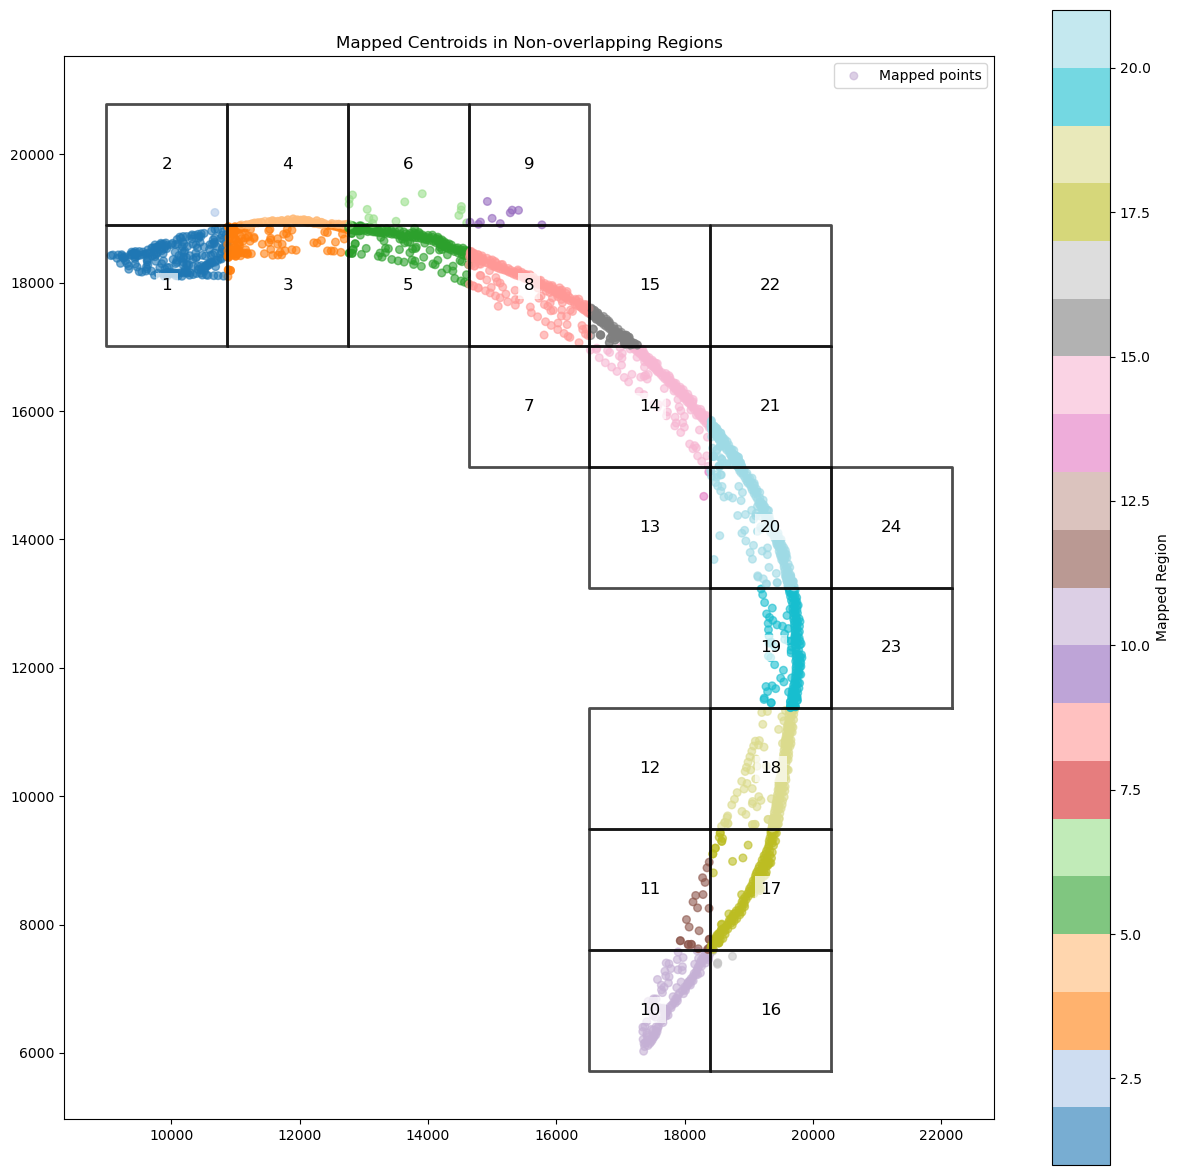


Results saved to: G:/Alexis_data/Project/SpatialOmics_cellpose/results/segmenatation/1835os


In [16]:
# Example usage:
if __name__ == "__main__":
    input_dir = 'G:/Alexis_data/Project/SpatialOmics_cellpose/results/segmenatation/1835os'
    
    # 1. Load and offset the centroid data using overlapping squares for offsets
    centroids_dict = load_and_offset_centroids(input_dir, overlapping_squares)
    
    # 2. Map offset centroids to non-overlapping regions
    mapped_df, outside_df = map_centroids_to_nonoverlapping(centroids_dict, non_overlapping_squares)
    
    # 3. Visualize the results
    visualize_mapped_centroids(mapped_df, outside_df, non_overlapping_squares)
    
    # 4. Save the results
    output_dir = input_dir
    mapped_df.to_csv(os.path.join(output_dir, 'mapped_centroids.csv'), index=False)
    if not outside_df.empty:
        outside_df.to_csv(os.path.join(output_dir, 'unmapped_centroids.csv'), index=False)
    print(f"\nResults saved to: {output_dir}")

Found 24 centroid files

Processing file: cp_masks_cropped_square_com_10_centroids.csv
Extracted region number: 10
Loaded 138 points from CSV
Region 10: processed 138 points, offset by (16515, 5724)

Processing file: cp_masks_cropped_square_com_11_centroids.csv
Extracted region number: 11
Loaded 33 points from CSV
Region 11: processed 33 points, offset by (16515, 7606)

Processing file: cp_masks_cropped_square_com_12_centroids.csv
Extracted region number: 12
Loaded 1 points from CSV
Region 12: processed 1 points, offset by (16515, 9488)

Processing file: cp_masks_cropped_square_com_13_centroids.csv
Extracted region number: 13
Loaded 0 points from CSV
Region 13: processed 0 points, offset by (16515, 11370)

Processing file: cp_masks_cropped_square_com_14_centroids.csv
Extracted region number: 14
Loaded 10 points from CSV
Region 14: processed 10 points, offset by (16515, 13252)

Processing file: cp_masks_cropped_square_com_15_centroids.csv
Extracted region number: 15
Loaded 219 points fr

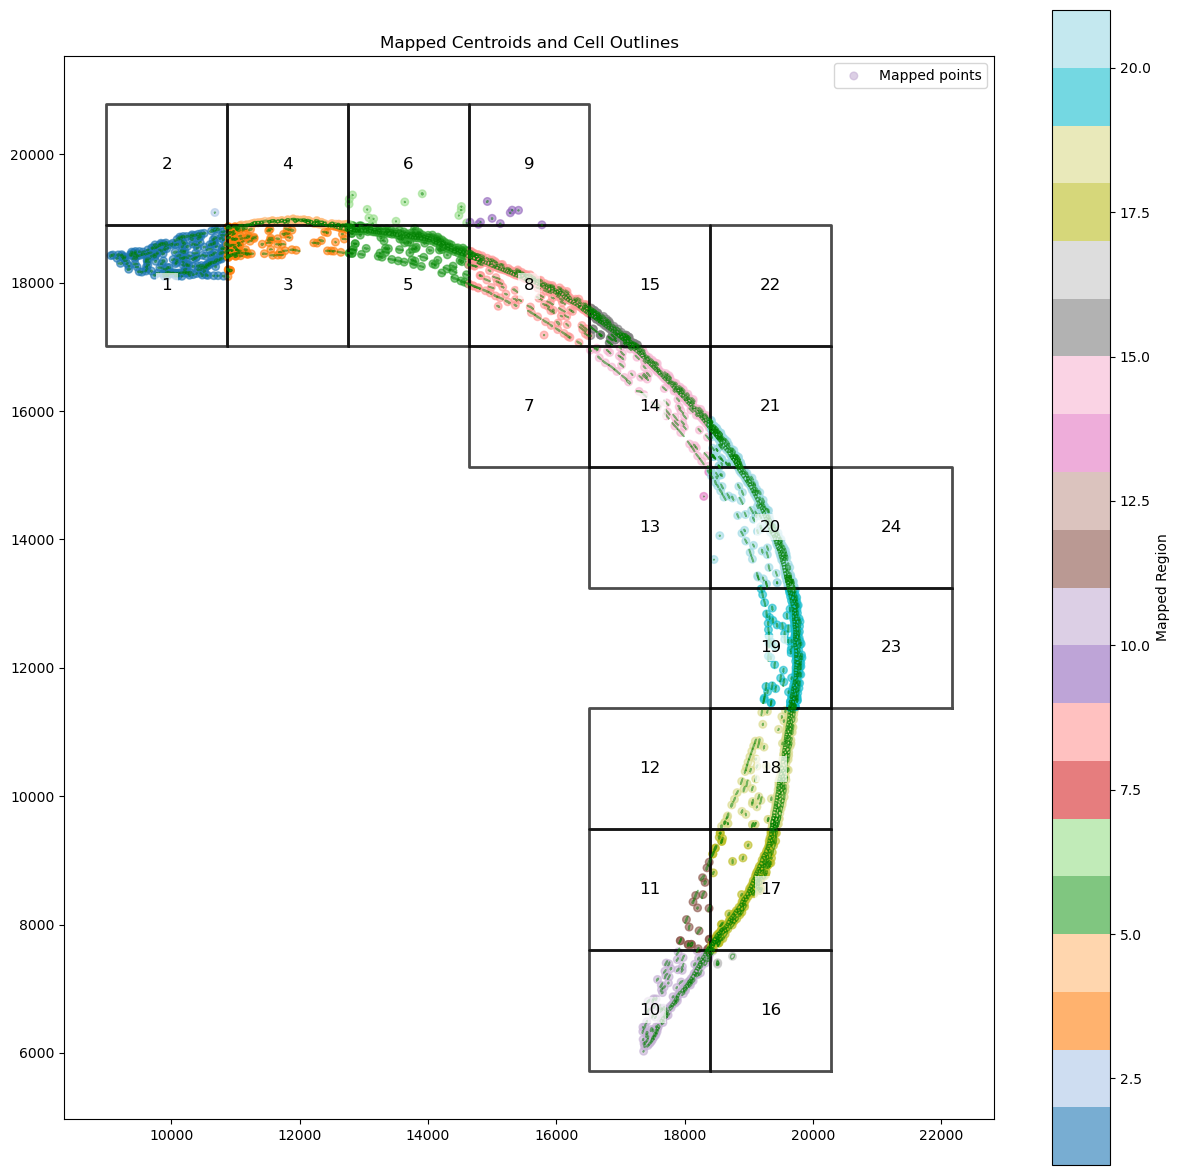


Results saved to: G:/Alexis_data/Project/SpatialOmics_cellpose/results/segmenatation/1835os


In [18]:
import pandas as pd
import numpy as np
import glob
import os
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from cellpose import utils

def load_and_offset_centroids(input_dir, overlapping_squares):
    """
    Load centroid CSV files and add offsets based on polygon bounds.
    """
    centroids_by_region = {}
    
    files = glob.glob(os.path.join(input_dir, '*centroids.csv'))
    print(f"Found {len(files)} centroid files")
    
    for file in files:
        try:
            filename = os.path.basename(file)
            print(f"\nProcessing file: {filename}")
            
            # Parse filename
            parts = filename.split('_')
            com_index = parts.index('com')
            region = int(parts[com_index + 1])
            print(f"Extracted region number: {region}")
            
            if region <= len(overlapping_squares):
                polygon = overlapping_squares[region - 1]
                min_x, min_y, max_x, max_y = map(int, polygon.bounds)
                
                df = pd.read_csv(file)
                print(f"Loaded {len(df)} points from CSV")
                
                # Add offsets to the centroid coordinates
                df['centroid_x'] = df['centroid_x'] + min_x
                df['centroid_y'] = df['centroid_y'] + min_y
                
                centroids_by_region[region] = df
                print(f"Region {region}: processed {len(df)} points, offset by ({min_x}, {min_y})")
            else:
                print(f"Warning: Region {region} has no corresponding polygon")
                
        except Exception as e:
            print(f"Error processing file {filename}: {str(e)}")
            continue
    
    return centroids_by_region

def map_centroids_to_nonoverlapping(centroids_dict, non_overlapping_squares):
    """
    Maps offset centroids to their corresponding non-overlapping squares.
    Returns both mapped centroids and mapping information for cell IDs.
    """
    mapped_centroids = []
    points_outside = []
    cell_mapping = {}  # To store which cells belong to which non-overlapping region
    
    for region, df in centroids_dict.items():
        print(f"Processing centroids from region {region}")
        cell_mapping[region] = {}  # Initialize mapping for this region
        
        for idx, row in df.iterrows():
            point = Point(row['centroid_x'], row['centroid_y'])
            point_mapped = False
            cell_id = idx + 1  # Assuming 1-based cell IDs
            
            for square_idx, square in enumerate(non_overlapping_squares):
                if square.contains(point):
                    mapped_data = {
                        'original_region': region,
                        'mapped_region': square_idx + 1,
                        'cell_id': cell_id,
                        'centroid_x': row['centroid_x'],
                        'centroid_y': row['centroid_y'],
                        'cell_type': row.get('cell_type', None),
                        'area': row.get('area', None)
                    }
                    mapped_centroids.append(mapped_data)
                    
                    # Store mapping information
                    if region not in cell_mapping:
                        cell_mapping[region] = {}
                    cell_mapping[region][cell_id] = square_idx + 1
                    
                    point_mapped = True
                    break
            
            if not point_mapped:
                points_outside.append({
                    'original_region': region,
                    'cell_id': cell_id,
                    'centroid_x': row['centroid_x'],
                    'centroid_y': row['centroid_y']
                })
    
    result_df = pd.DataFrame(mapped_centroids)
    outside_df = pd.DataFrame(points_outside)
    
    print(f"\nTotal centroids processed: {len(result_df)}")
    print(f"Points not mapped to any square: {len(outside_df)}")
    if not result_df.empty:
        print("\nCentroids per mapped region:")
        print(result_df['mapped_region'].value_counts().sort_index())
    
    return result_df, outside_df, cell_mapping

def map_and_filter_outlines(input_dir, overlapping_squares, cell_mapping):
    """
    Load, filter, and map outlines based on the cell mapping from centroids.
    """
    filtered_outlines_list = []
    region_info = []
    
    for region, valid_cells_dict in cell_mapping.items():
        if not valid_cells_dict:  # Skip if no valid cells in this region
            continue
            
        try:
            # Get region bounds
            polygon = overlapping_squares[region - 1]
            min_x, min_y, max_x, max_y = map(int, polygon.bounds)
            
            # Load segmentation data
            seg_file = os.path.join(input_dir, f'cp_masks_cropped_square_com_{region}_seg.npy')
            seg_data = np.load(seg_file, allow_pickle=True).item()
            outlines = utils.outlines_list(seg_data['masks'])
            
            # Filter and map outlines
            for cell_id, mapped_region in valid_cells_dict.items():
                if cell_id <= len(outlines):  # Make sure we have this outline
                    outline = outlines[cell_id - 1]  # Convert to 0-based index
                    # Add offset to outline coordinates
                    mapped_outline = outline + np.array([min_x, min_y])
                    filtered_outlines_list.append(mapped_outline)
                    region_info.append({
                        'original_region': region,
                        'mapped_region': mapped_region,
                        'cell_id': cell_id
                    })
            
            print(f"Region {region}: Processed {len(valid_cells_dict)} outlines")
            
        except Exception as e:
            print(f"Error processing outlines for region {region}: {str(e)}")
            continue
    
    return filtered_outlines_list, pd.DataFrame(region_info)

def visualize_mapped_data(result_df, outside_df, filtered_outlines_list, non_overlapping_squares, figsize=(15, 15)):
    """
    Visualizes the mapped centroids, outlines, and squares.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot non-overlapping squares
    for idx, square in enumerate(non_overlapping_squares):
        x, y = square.exterior.xy
        ax.plot(x, y, 'k-', linewidth=2, alpha=0.7)
        centroid = square.centroid
        ax.text(centroid.x, centroid.y, str(idx + 1), 
                horizontalalignment='center', 
                verticalalignment='center',
                fontsize=12,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    # Plot mapped centroids
    if not result_df.empty:
        scatter = ax.scatter(result_df['centroid_x'], result_df['centroid_y'], 
                           c=result_df['mapped_region'], 
                           cmap='tab20', 
                           alpha=0.6, 
                           s=30,
                           label='Mapped points')
        plt.colorbar(scatter, label='Mapped Region')
    
    # Plot points outside any square
    if not outside_df.empty:
        ax.scatter(outside_df['centroid_x'], outside_df['centroid_y'], 
                  color='red', 
                  alpha=0.6, 
                  s=30,
                  label='Unmapped points')
    
    # Plot outlines
    for outline in filtered_outlines_list:
        ax.plot(outline[:, 0], outline[:, 1], 'g-', linewidth=1, alpha=0.5)
    
    ax.set_title('Mapped Centroids and Cell Outlines')
    ax.legend()
    ax.set_aspect('equal')
    plt.show()

# Example usage:
if __name__ == "__main__":
    input_dir = 'G:/Alexis_data/Project/SpatialOmics_cellpose/results/segmenatation/1835os'
    
    # 1. Load and offset centroids
    centroids_dict = load_and_offset_centroids(input_dir, overlapping_squares)
    
    # 2. Map centroids and get cell mapping
    mapped_df, outside_df, cell_mapping = map_centroids_to_nonoverlapping(centroids_dict, non_overlapping_squares)
    
    # 3. Load and map outlines
    filtered_outlines_list, outline_info = map_and_filter_outlines(input_dir, overlapping_squares, cell_mapping)
    
    # 4. Visualize results
    visualize_mapped_data(mapped_df, outside_df, filtered_outlines_list, non_overlapping_squares)
    
    # 5. Save results
    output_dir = input_dir
    mapped_df.to_csv(os.path.join(output_dir, 'mapped_centroids.csv'), index=False)
    if not outside_df.empty:
        outside_df.to_csv(os.path.join(output_dir, 'unmapped_centroids.csv'), index=False)
    outline_info.to_csv(os.path.join(output_dir, 'outline_mapping.csv'), index=False)
    print(f"\nResults saved to: {output_dir}")

In [19]:
def boundaries_to_table(boundaries):
    # Create an empty list to store data rows
    data = []
    
    # Loop through each boundary (each cell)
    for cell_id, boundary in enumerate(boundaries, start=1):
        # Loop through each point in the boundary
        for point in boundary:
            # Append cell_id, x, y to the data list
            data.append([cell_id, point[0], point[1]])
    
    # Create a DataFrame with the data
    df = pd.DataFrame(data, columns=['cell_id', 'vertex_x', 'vertex_y'])
    
    return df


In [20]:
# Convert boundaries to table
df_outlines_list = boundaries_to_table(filtered_outlines_list)

In [21]:
df_outlines_list

,cell_id,vertex_x,vertex_y
0,1,17354,6019
1,1,17354,6020
2,1,17354,6021
3,1,17353,6022
4,1,17353,6023
...,...,...,...
261825,2052,14925,19257
261826,2052,14924,19256
261827,2052,14923,19256
261828,2052,14922,19256


In [22]:
df_outlines_list.to_csv('G:/Alexis_data/Project/SpatialOmics_cellpose/results/segmenatation/1835os/cellpose_cell_boundaries_1835os_origin.csv', index=False)
print("Saved successly" )

Saved successly


In [23]:
def reduce_points(df):
    # Group by cell_id and get counts
    cell_counts = df.groupby('cell_id').size()
    
    new_df = pd.DataFrame()
    
    for cell_id in cell_counts.index:
        cell_data = df[df['cell_id'] == cell_id]
        
        if cell_counts[cell_id] > 50:
            # Keep every other row until we have 50 points
            reduced_data = cell_data.iloc[::2].head(50)
        elif 30 < cell_counts[cell_id] <= 50:
            # Keep every other row until we have 30 points
            reduced_data = cell_data.iloc[::2].head(30)
        else:
            # Keep all points if count <= 30
            reduced_data = cell_data
            
        new_df = pd.concat([new_df, reduced_data])
    
    return new_df.reset_index(drop=True)

In [24]:
# Apply the function
reduced_outlines_list = reduce_points(df_outlines_list)

# Print the results
print("Original shape:", df_outlines_list.shape)
print("Reduced shape:", reduced_outlines_list.shape)


Original shape: (261830, 3)
Reduced shape: (97317, 3)


In [25]:
reduced_outlines_list.to_csv('G:/Alexis_data/Project/SpatialOmics_cellpose/results/segmenatation/1835os/cellpose_cell_boundaries_1835os.csv', index=False)
print("Saved successly" )

Saved successly


In [26]:
unique_cell_count = reduced_outlines_list['cell_id'].nunique()
# unique_cell_count = boundary_df['cell_id'].nunique()

unique_cell_count

2052

In [27]:
def calculate_centroids(df):
    # Group the DataFrame by 'cell_id'
    grouped = df.groupby('cell_id')
    
    # Calculate centroids for each group
    centroids = grouped[['vertex_x', 'vertex_y']].mean().reset_index()
    
    # Rename columns if needed to indicate centroids explicitly
    centroids.rename(columns={'vertex_x': 'centroid_x', 'vertex_y': 'centroid_y'}, inplace=True)
    
    return centroids


In [28]:
# Calculate centroids for each cell
centroids_df = calculate_centroids(reduced_outlines_list)
centroids_df

,cell_id,centroid_x,centroid_y
0,1,17358.684211,6025.947368
1,2,17374.642857,6099.392857
2,3,17424.913043,6113.934783
3,4,17453.571429,6145.918367
4,5,17365.170213,6147.148936
...,...,...,...
2047,2048,14997.720000,19004.040000
2048,2049,15280.941176,19091.000000
2049,2050,15310.333333,19131.809524
2050,2051,15409.058824,19129.705882


In [29]:
centroids_df.to_csv('G:/Alexis_data/Project/SpatialOmics_cellpose/results/segmenatation/1835os/cellpose_cell_centroids_1835os.csv', index=False)
print("Saved successly" )

Saved successly


In [30]:
# Process to append the first row of each cell group
Outlines_list_final = (
    reduced_outlines_list.groupby('cell_id', group_keys=False)
    .apply(lambda group: pd.concat([group, group.iloc[[0]]], ignore_index=True))
)

Outlines_list_final

C:\Users\Alexis\AppData\Local\Temp\ipykernel_79536\3904916442.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.concat([group, group.iloc[[0]]], ignore_index=True))


,cell_id,vertex_x,vertex_y
0,1,17354,6019
1,1,17354,6021
2,1,17353,6023
3,1,17353,6025
4,1,17353,6027
...,...,...,...
29,2052,14928,19259
30,2052,14926,19257
31,2052,14924,19256
32,2052,14922,19256


In [31]:
Outlines_list_final.to_csv('G:/Alexis_data/Project/SpatialOmics_cellpose/results/segmenatation/1835od/cellpose_cell_boundaries_1835os.csv', index=False)
print("Saved successly" )

Saved successly
